In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, time
sys.path.append("..")
import copy
import subprocess
import numpy as np
import matplotlib.pyplot as plt

import rasterio
import fiona
import shapely.geometry

import utils

In [2]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [3]:
def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

def get_angle(point1, point2):
    degrees = azimuth(point1, point2)
    return degrees * np.pi / 180

def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [4]:
xs = []
with fiona.open("../data/usgs_labels/Delmarva_PL_House_Final2.shp") as f:
    for row in f:
        geom = row["geometry"]
        shape = shapely.geometry.shape(geom)
        shape = shape.minimum_rotated_rectangle
        
        points = list(shape.exterior.coords)
        max_dist = 0
        max_idx = None
        for i in range(4):
            dist = distance(points[i], points[i+1])
            if dist >= max_dist:
                max_dist = dist
                max_idx = i
        
        for i in range(4):
            dist = distance(points[i], points[i+1])
            if dist == max_dist:
                point1 = points[i]
                point2 = points[i+1]
                radians = get_angle(point1, point2)
                xs.append(radians)
xs = np.array(xs)

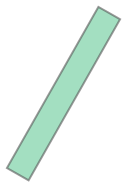

In [5]:
shape

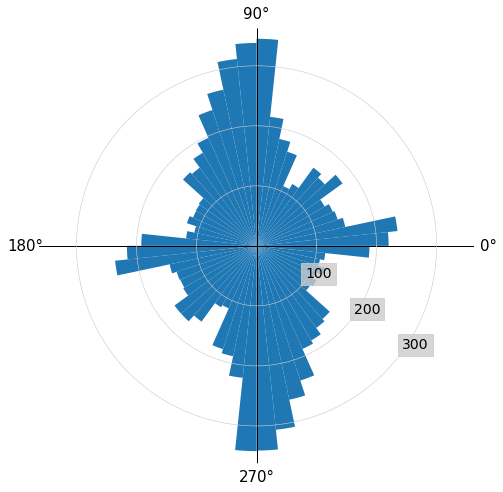

In [6]:
offset=360-36
offset_r = 350
fig, ax = plt.subplots(1,1,figsize=(8,8), subplot_kw=dict(projection='polar'))

hist, bin_edges, patches = circular_hist(ax, np.array(xs), density=False, bins=60, gaps=True)
#plt.plot([(180+offset)*np.pi/180,offset*np.pi/180], [offset_r,offset_r], color="#ccc", linewidth=0.5, zorder=1)

ax.set_rlabel_position(offset)

plt.yticks([100,200,300], fontsize=14, backgroundcolor="#cccc")
plt.tick_params(axis="y", zorder=3)
plt.xticks([0,np.pi/2,np.pi, 3*np.pi/2], fontsize=15)

#ax.grid(False)


ax.grid(b=True, which='major', axis='x', color='#000', linestyle='-', linewidth=1)
ax.grid(b=False, which='minor', axis='x', color='#000', linestyle='-', linewidth=1)
ax.grid(b=True, which='major', axis='y', color='#ccc', linestyle='-', linewidth=0.6, zorder=0)
ax.grid(b=False, which='minor', axis='y')

ax.spines['polar'].set_visible(False)

plt.show()
plt.close()

In [7]:
(bin_edges * 180 / np.pi).round(2)

array([-180., -174., -168., -162., -156., -150., -144., -138., -132.,
       -126., -120., -114., -108., -102.,  -96.,  -90.,  -84.,  -78.,
        -72.,  -66.,  -60.,  -54.,  -48.,  -42.,  -36.,  -30.,  -24.,
        -18.,  -12.,   -6.,   -0.,    6.,   12.,   18.,   24.,   30.,
         36.,   42.,   48.,   54.,   60.,   66.,   72.,   78.,   84.,
         90.,   96.,  102.,  108.,  114.,  120.,  126.,  132.,  138.,
        144.,  150.,  156.,  162.,  168.,  174.,  180.])